In [4]:
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt

In [21]:
thetas = np.linspace(0, 1, 1001) # 연속값을 그대로 다룰 수 없어서 가능한 세세하게 간격을 나눈 확률 변수의 배열을 준비, 클릴률에 대한 신념 변수를 확률 질량 변수로 근사화
print(thetas)

[0.    0.001 0.002 ... 0.998 0.999 1.   ]


In [22]:
#우도 함수
likelihood = lambda r: thetas if r else (1 - thetas)

In [23]:
#사후 분포
def posterior(r, prior):
    lp = likelihood(r) * prior # 우도 함수와 사전 분포의 곱
    return lp / lp.sum()

In [24]:
p = np.array([ 1 / len(thetas) for _ in thetas ])

In [25]:
# 베이즈 추론
p = posterior(1, p) #클릭 한번 : 즉, r=1이 주어졌을 때의 사후 분포 계산
print(p)

[0.00000000e+00 1.99800200e-06 3.99600400e-06 ... 1.99400599e-03
 1.99600400e-03 1.99800200e-03]


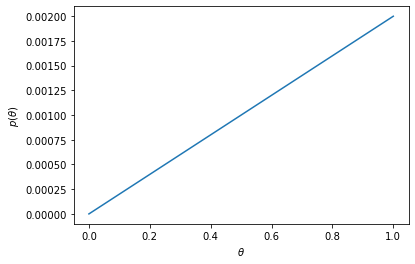

In [26]:
#맷플롯립을 이용한 사후 분포 시각화
from matplotlib import pyplot as plt

plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.show()

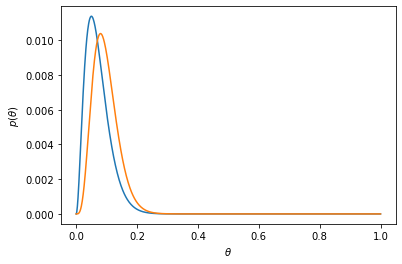

In [29]:
#앨리스의 보고서 디자인 A안, B안
alice_a_clicks = 2
alice_a_noclicks = 38

p_alice_a = np.array([1/len(thetas) for theta in thetas])
for _ in range(alice_a_clicks):
    p_alice_a = posterior(1, p_alice_a)
for _ in range(alice_a_noclicks):
    p_alice_a = posterior(0, p_alice_a)
    
alick_b_clicks = 4
alick_b_noclicks = 46

p_alice_b = np.array([1/len(thetas) for theta in thetas])
for _ in range(alick_b_clicks):
    p_alice_b = posterior(1, p_alice_b)
for _ in range(alick_b_noclicks):
    p_alice_b = posterior(0, p_alice_b)
    
plt.plot(thetas, p_alice_a)
plt.plot(thetas, p_alice_b)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.show()

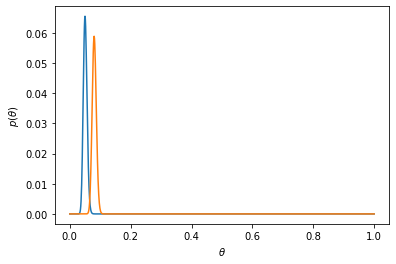

In [31]:
#밥의 보고서 디자인 A안, B안
bob_a_clicks = 64
bob_a_noclicks = 1280-bob_a_clicks

p_bob_a = np.array([1/len(thetas) for theta in thetas])
for _ in range(bob_a_clicks):
    p_bob_a = posterior(1, p_bob_a)
for _ in range(bob_a_noclicks):
    p_bob_a = posterior(0, p_bob_a)
    
bob_b_clicks = 128
bob_b_noclicks = 1600 - bob_b_clicks

p_bob_b = np.array([1/len(thetas) for theta in thetas])
for _ in range(bob_b_clicks):
    p_bob_b = posterior(1, p_bob_b)
for _ in range(bob_b_noclicks):
    p_bob_b = posterior(0, p_bob_b)
    
plt.plot(thetas, p_bob_a)
plt.plot(thetas, p_bob_b)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.show()

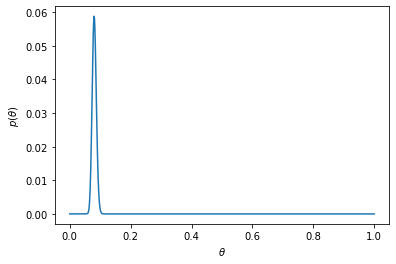

In [35]:
#베르누이 분포 대신 이항 분포 사용

likelihood = lambda a, N: thetas ** a * (1 - thetas) ** (N - a)   # theta를 포함하지 않는 계수는 생략

def posterior(a, N, prior):
    lp = likelihood(a, N) * prior
    return lp / lp.sum()

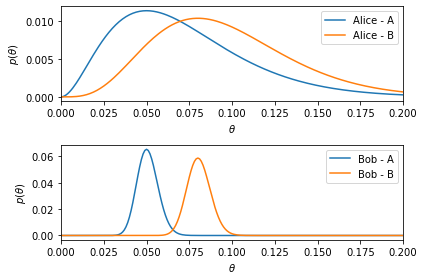

In [37]:
prior = 1 / len(thetas)

plt.subplot(2, 1, 1)
plt.plot(thetas, posterior(2, 40, prior), label = 'Alice - A')
plt.plot(thetas, posterior(4, 50, prior), label = 'Alice - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior(64, 1280, prior), label = 'Bob - A')
plt.plot(thetas, posterior(128, 1600, prior), label = 'Bob - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.tight_layout()
plt.legend()

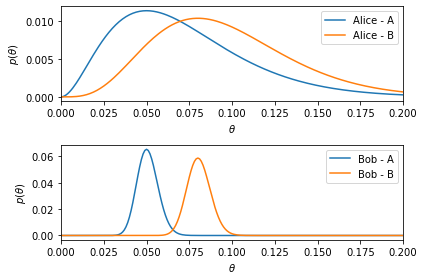

In [39]:
#베타 분포 : 사후 분포의 확률 분포
#켤레 사전 분포 : 어떤 가능도 함수에 대해 사후 분포와 사전 분포를 같은 종류의 확률 분포로 나타낼 수 있는 특징을 가진 사전 분포

def betaf(alpha, beta):
    numerator = thetas ** (alpha - 1) * (1 - thetas) ** (beta - 1)
    return numerator / numerator.sum()

def posterior(a, N):
    return betaf(a + 1, N - a + 1)

plt.subplot(2, 1, 1)
plt.plot(thetas, posterior(2, 40), label='Alice - A')
plt.plot(thetas, posterior(4, 50), label='Alice - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior(64, 1280), label = 'Bob - A')
plt.plot(thetas, posterior(128, 1600), label = 'Bob - B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.2)
plt.tight_layout()
plt.legend()

In [3]:
# HDI (highest density interval) : 연속 확률 분포에 대해 정의되는 값. 다양한 확률 변수의 값을 확률 밀도가 높은 순으로 어떤 확률에 이를 때까지를 커버한 것.
# 예를 들어 확률 0.95에 이를때까지 확류 ㄹ밀도가 높은 것부터 채운 영역을 95% HDI라고 부름.

#HDI를 이용한 가설 검정

# 각 디자인안의 클릴률의 사후분포 hDI를 구해보기

def hmv(xs, ps, alpha=0.95):
    xps = sorted(zip(xs, ps), key=lambda xp: xp[1], reverse=True)
    xps = np.array(xps)
    xs = xps[:, 0]
    ps = xps[:, 1]
    return np.sort(xs[np.cumsum(ps) <= alpha])

thetas = np.linspace(0, 1, 1001)

def posterior(a, N):
    alpha = a + 1
    beta = N - a + 1
    numerator = thetas ** (alpha - 1) * (1 - thetas) ** (beta - 1)
    return numerator / numerator.sum()

ps = posterior(2, 40)

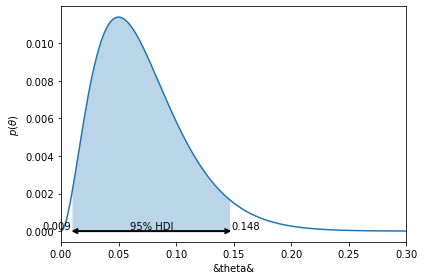

In [7]:
hm_thetas = hmv(thetas, ps, alpha=0.95)
plt.plot(thetas, ps)
plt.annotate('', xy=(hm_thetas.min(), 0),
                xytext=(hm_thetas.max(), 0),
                arrowprops = dict(color = 'black', shrinkA=0, shrinkB=0, arrowstyle='<->', linewidth=2))
plt.annotate('%.3f' % hm_thetas.min(), xy=(hm_thetas.min(), 0), ha='right', va = 'bottom')
plt.annotate('%.3f' % hm_thetas.max(), xy=(hm_thetas.max(), 0), ha='left', va = 'bottom')
plt.annotate('95% HDI', xy=(hm_thetas.mean(), 0), ha='center', va='bottom')
hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
plt.fill_between(thetas[hm_region], ps[hm_region], 0, alpha=0.3)
plt.xlabel(r'&theta&')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.3)
plt.tight_layout()
plt.show()